# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 1024

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.Rotate(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

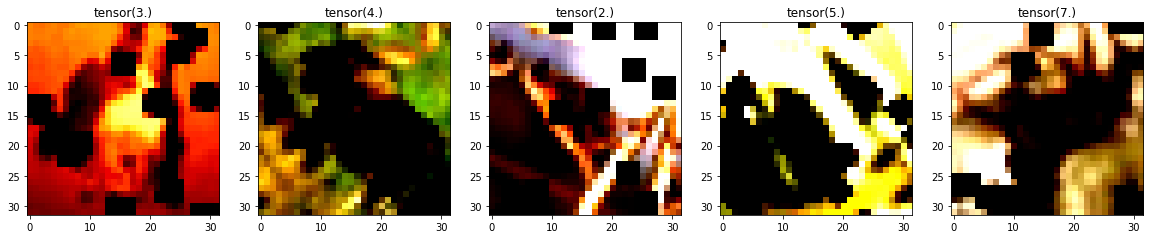

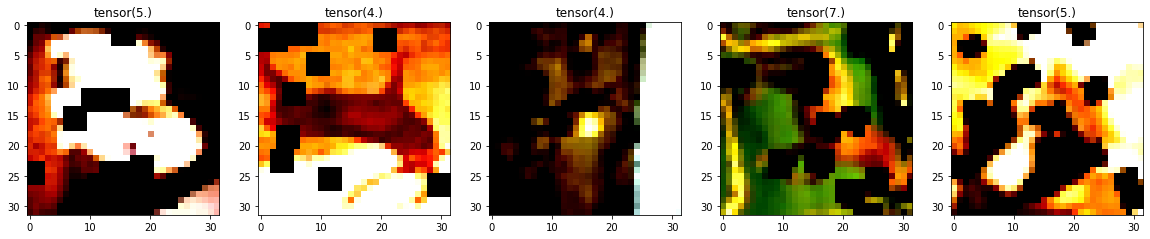

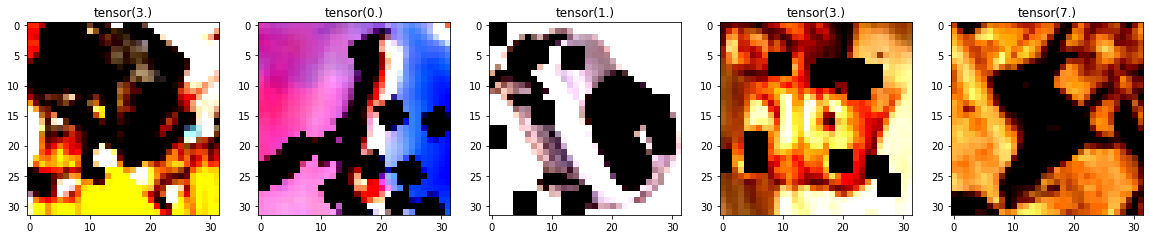

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from pact_utils import QuantizedLinear, QuantizedConv2d


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # Relu is implemented as the input of conv2d
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.k = K

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2, expansion=1)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = nn.Linear(256, num_classes, bias=False)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 3, 3, 3], K=k)

In [13]:
net = resnet20(8)

bit width: 8


# Train with quantization

In [14]:
from timm.scheduler import CosineLRScheduler

for k in range(1):
    net = resnet20(k=k)

    model = net.cuda()
    mixup = False

    # Track experiment with wandb
    import wandb
    watermark = "resnet18_noquant".format(k)

    # mess with wandb
    wandb.init(project="quantize_resnet", name=watermark)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    # optimizer for pact
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                momentum=0.9,
                                weight_decay=0.0002)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

bit width: 0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
prec,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
train_loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,0.0
prec,83.67
train_loss,0.49557
val_loss,0.50641


current lr 1.00000e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [0][0/40]	Time 1.503 (1.503)	Data 1.298 (1.298)	Loss 6.1149 (6.1149)	Prec@1 10.938 (10.938)
Test: [0/10]	Time 0.600 (0.600)	Loss 5.1598 (5.1598)	Prec@1 10.059 (10.059)
 * Prec@1 10.000
alpha1 9.999961853027344
Best prec1 :  9.999999987792968
current lr 3.34000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [1][0/40]	Time 1.272 (1.272)	Data 1.066 (1.066)	Loss 6.0581 (6.0581)	Prec@1 8.691 (8.691)
Test: [0/10]	Time 0.628 (0.628)	Loss 2.1682 (2.1682)	Prec@1 23.438 (23.438)
 * Prec@1 22.800
alpha1 9.986610412597656
Best prec1 :  22.799999978637697
current lr 6.67000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [2][0/40]	Time 1.617 (1.617)	Data 1.410 (1.410)	Loss 2.2056 (2.2056)	Prec@1 26.270 (26.270)
Test: [0/10]	Time 0.674 (0.674)	Loss 1.9024 (1.9024)	Prec@1 29.688 (29.688)
 * Prec@1 29.580
alpha1 9.959967613220215
Best prec1 :  29.580000048828126
current lr 1.00000e-03


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [3][0/40]	Time 1.200 (1.200)	Data 0.992 (0.992)	Loss 2.1205 (2.1205)	Prec@1 29.980 (29.980)
Test: [0/10]	Time 0.691 (0.691)	Loss 1.8755 (1.8755)	Prec@1 32.617 (32.617)
 * Prec@1 32.930
alpha1 9.920103073120117
Best prec1 :  32.93
current lr 9.99938e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [4][0/40]	Time 1.268 (1.268)	Data 1.060 (1.060)	Loss 1.9813 (1.9813)	Prec@1 34.277 (34.277)
Test: [0/10]	Time 0.644 (0.644)	Loss 1.8065 (1.8065)	Prec@1 36.621 (36.621)
 * Prec@1 35.790
alpha1 9.880339622497559
Best prec1 :  35.79000010986328
current lr 9.99754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [5][0/40]	Time 1.333 (1.333)	Data 1.124 (1.124)	Loss 1.9038 (1.9038)	Prec@1 34.961 (34.961)
Test: [0/10]	Time 0.711 (0.711)	Loss 1.6732 (1.6732)	Prec@1 38.379 (38.379)
 * Prec@1 40.130
alpha1 9.840672492980957
Best prec1 :  40.130000012207034
current lr 9.99445e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [6][0/40]	Time 1.383 (1.383)	Data 1.172 (1.172)	Loss 1.7956 (1.7956)	Prec@1 43.457 (43.457)
Test: [0/10]	Time 0.700 (0.700)	Loss 1.9781 (1.9781)	Prec@1 38.086 (38.086)
 * Prec@1 37.800
alpha1 9.801104545593262
Best prec1 :  40.130000012207034
current lr 9.99014e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [7][0/40]	Time 1.563 (1.563)	Data 1.353 (1.353)	Loss 1.7896 (1.7896)	Prec@1 44.434 (44.434)
Test: [0/10]	Time 0.585 (0.585)	Loss 1.5882 (1.5882)	Prec@1 43.359 (43.359)
 * Prec@1 43.390
alpha1 9.761632919311523
Best prec1 :  43.389999981689456
current lr 9.98460e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [8][0/40]	Time 1.690 (1.690)	Data 1.479 (1.479)	Loss 1.7286 (1.7286)	Prec@1 46.582 (46.582)
Test: [0/10]	Time 0.605 (0.605)	Loss 1.4925 (1.4925)	Prec@1 47.363 (47.363)
 * Prec@1 46.660
alpha1 9.722261428833008
Best prec1 :  46.65999989013672
current lr 9.97783e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [9][0/40]	Time 1.369 (1.369)	Data 1.158 (1.158)	Loss 1.7083 (1.7083)	Prec@1 44.824 (44.824)
Test: [0/10]	Time 0.651 (0.651)	Loss 1.4527 (1.4527)	Prec@1 47.852 (47.852)
 * Prec@1 48.460
alpha1 9.682992935180664
Best prec1 :  48.45999993896484
current lr 9.96983e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [10][0/40]	Time 1.388 (1.388)	Data 1.176 (1.176)	Loss 1.6935 (1.6935)	Prec@1 45.605 (45.605)
Test: [0/10]	Time 0.646 (0.646)	Loss 1.5131 (1.5131)	Prec@1 50.488 (50.488)
 * Prec@1 49.310
alpha1 9.643830299377441
Best prec1 :  49.30999990234375
current lr 9.96061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [11][0/40]	Time 1.435 (1.435)	Data 1.221 (1.221)	Loss 1.6458 (1.6458)	Prec@1 48.242 (48.242)
Test: [0/10]	Time 0.737 (0.737)	Loss 1.4110 (1.4110)	Prec@1 50.000 (50.000)
 * Prec@1 48.800
alpha1 9.604776382446289
Best prec1 :  49.30999990234375
current lr 9.95017e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [12][0/40]	Time 1.367 (1.367)	Data 1.153 (1.153)	Loss 1.5861 (1.5861)	Prec@1 51.855 (51.855)
Test: [0/10]	Time 0.582 (0.582)	Loss 1.4183 (1.4183)	Prec@1 50.391 (50.391)
 * Prec@1 49.770
alpha1 9.565834045410156
Best prec1 :  49.769999951171876
current lr 9.93850e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [13][0/40]	Time 1.334 (1.334)	Data 1.121 (1.121)	Loss 1.5380 (1.5380)	Prec@1 50.977 (50.977)
Test: [0/10]	Time 0.668 (0.668)	Loss 1.3796 (1.3796)	Prec@1 51.367 (51.367)
 * Prec@1 50.580
alpha1 9.527007102966309
Best prec1 :  50.58000009765625
current lr 9.92562e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [14][0/40]	Time 1.319 (1.319)	Data 1.105 (1.105)	Loss 1.5542 (1.5542)	Prec@1 50.000 (50.000)
Test: [0/10]	Time 0.642 (0.642)	Loss 1.4208 (1.4208)	Prec@1 52.344 (52.344)
 * Prec@1 51.260
alpha1 9.488299369812012
Best prec1 :  51.25999987792969
current lr 9.91152e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [15][0/40]	Time 1.327 (1.327)	Data 1.113 (1.113)	Loss 1.5496 (1.5496)	Prec@1 52.832 (52.832)
Test: [0/10]	Time 0.608 (0.608)	Loss 1.3025 (1.3025)	Prec@1 54.785 (54.785)
 * Prec@1 52.270
alpha1 9.449712753295898
Best prec1 :  52.26999989013672
current lr 9.89622e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [16][0/40]	Time 1.522 (1.522)	Data 1.308 (1.308)	Loss 1.5503 (1.5503)	Prec@1 52.148 (52.148)
Test: [0/10]	Time 0.710 (0.710)	Loss 1.4086 (1.4086)	Prec@1 51.758 (51.758)
 * Prec@1 50.020
alpha1 9.411249160766602
Best prec1 :  52.26999989013672
current lr 9.87970e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [17][0/40]	Time 1.558 (1.558)	Data 1.344 (1.344)	Loss 1.4802 (1.4802)	Prec@1 52.832 (52.832)
Test: [0/10]	Time 0.714 (0.714)	Loss 1.2954 (1.2954)	Prec@1 55.176 (55.176)
 * Prec@1 53.320
alpha1 9.372915267944336
Best prec1 :  53.319999847412106
current lr 9.86199e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [18][0/40]	Time 1.753 (1.753)	Data 1.539 (1.539)	Loss 1.4062 (1.4062)	Prec@1 55.957 (55.957)
Test: [0/10]	Time 0.597 (0.597)	Loss 1.2150 (1.2150)	Prec@1 58.008 (58.008)
 * Prec@1 56.820
alpha1 9.334712028503418
Best prec1 :  56.81999989624023
current lr 9.84307e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [19][0/40]	Time 1.603 (1.603)	Data 1.389 (1.389)	Loss 1.3511 (1.3511)	Prec@1 57.422 (57.422)
Test: [0/10]	Time 0.625 (0.625)	Loss 1.2420 (1.2420)	Prec@1 58.008 (58.008)
 * Prec@1 55.840
alpha1 9.296646118164062
Best prec1 :  56.81999989624023
current lr 9.82296e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [20][0/40]	Time 1.290 (1.290)	Data 1.075 (1.075)	Loss 1.3686 (1.3686)	Prec@1 56.152 (56.152)
Test: [0/10]	Time 0.596 (0.596)	Loss 1.2207 (1.2207)	Prec@1 58.789 (58.789)
 * Prec@1 55.580
alpha1 9.25871467590332
Best prec1 :  56.81999989624023
current lr 9.80167e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [21][0/40]	Time 1.584 (1.584)	Data 1.370 (1.370)	Loss 1.3318 (1.3318)	Prec@1 58.301 (58.301)
Test: [0/10]	Time 0.685 (0.685)	Loss 1.1859 (1.1859)	Prec@1 58.887 (58.887)
 * Prec@1 56.940
alpha1 9.220929145812988
Best prec1 :  56.939999865722655
current lr 9.77919e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [22][0/40]	Time 1.681 (1.681)	Data 1.466 (1.466)	Loss 1.3687 (1.3687)	Prec@1 57.422 (57.422)
Test: [0/10]	Time 0.725 (0.725)	Loss 1.1246 (1.1246)	Prec@1 60.449 (60.449)
 * Prec@1 58.810
alpha1 9.183290481567383
Best prec1 :  58.80999991455078
current lr 9.75553e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [23][0/40]	Time 1.722 (1.722)	Data 1.508 (1.508)	Loss 1.3192 (1.3192)	Prec@1 58.984 (58.984)
Test: [0/10]	Time 0.661 (0.661)	Loss 1.1612 (1.1612)	Prec@1 60.059 (60.059)
 * Prec@1 58.600
alpha1 9.145798683166504
Best prec1 :  58.80999991455078
current lr 9.73070e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [24][0/40]	Time 1.397 (1.397)	Data 1.182 (1.182)	Loss 1.2472 (1.2472)	Prec@1 60.742 (60.742)
Test: [0/10]	Time 0.612 (0.612)	Loss 1.2018 (1.2018)	Prec@1 58.398 (58.398)
 * Prec@1 56.800
alpha1 9.108458518981934
Best prec1 :  58.80999991455078
current lr 9.70470e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [25][0/40]	Time 1.719 (1.719)	Data 1.505 (1.505)	Loss 1.2314 (1.2314)	Prec@1 62.793 (62.793)
Test: [0/10]	Time 0.720 (0.720)	Loss 0.9852 (0.9852)	Prec@1 66.016 (66.016)
 * Prec@1 63.500
alpha1 9.071272850036621
Best prec1 :  63.499999792480466
current lr 9.67754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [26][0/40]	Time 1.691 (1.691)	Data 1.476 (1.476)	Loss 1.1923 (1.1923)	Prec@1 64.551 (64.551)
Test: [0/10]	Time 0.693 (0.693)	Loss 0.9899 (0.9899)	Prec@1 65.723 (65.723)
 * Prec@1 63.640
alpha1 9.034245491027832
Best prec1 :  63.63999975585938
current lr 9.64923e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [27][0/40]	Time 1.601 (1.601)	Data 1.386 (1.386)	Loss 1.1838 (1.1838)	Prec@1 62.207 (62.207)
Test: [0/10]	Time 0.608 (0.608)	Loss 1.0562 (1.0562)	Prec@1 63.574 (63.574)
 * Prec@1 61.650
alpha1 8.997376441955566
Best prec1 :  63.63999975585938
current lr 9.61978e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [28][0/40]	Time 1.347 (1.347)	Data 1.131 (1.131)	Loss 1.2025 (1.2025)	Prec@1 62.305 (62.305)
Test: [0/10]	Time 0.627 (0.627)	Loss 1.0492 (1.0492)	Prec@1 63.965 (63.965)
 * Prec@1 62.640
alpha1 8.960668563842773
Best prec1 :  63.63999975585938
current lr 9.58918e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [29][0/40]	Time 1.426 (1.426)	Data 1.211 (1.211)	Loss 1.2129 (1.2129)	Prec@1 61.816 (61.816)
Test: [0/10]	Time 0.584 (0.584)	Loss 1.0696 (1.0696)	Prec@1 64.355 (64.355)
 * Prec@1 62.850
alpha1 8.92413330078125
Best prec1 :  63.63999975585938
current lr 9.55746e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [30][0/40]	Time 1.685 (1.685)	Data 1.471 (1.471)	Loss 1.2254 (1.2254)	Prec@1 63.672 (63.672)
Test: [0/10]	Time 0.599 (0.599)	Loss 0.9191 (0.9191)	Prec@1 68.555 (68.555)
 * Prec@1 66.190
alpha1 8.887763977050781
Best prec1 :  66.18999998779297
current lr 9.52461e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [31][0/40]	Time 1.240 (1.240)	Data 1.025 (1.025)	Loss 1.1821 (1.1821)	Prec@1 62.500 (62.500)
Test: [0/10]	Time 0.622 (0.622)	Loss 1.0791 (1.0791)	Prec@1 63.574 (63.574)
 * Prec@1 62.630
alpha1 8.851572036743164
Best prec1 :  66.18999998779297
current lr 9.49065e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [32][0/40]	Time 1.565 (1.565)	Data 1.349 (1.349)	Loss 1.1200 (1.1200)	Prec@1 66.504 (66.504)
Test: [0/10]	Time 0.598 (0.598)	Loss 0.9699 (0.9699)	Prec@1 66.309 (66.309)
 * Prec@1 64.680
alpha1 8.8155517578125
Best prec1 :  66.18999998779297
current lr 9.45558e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [33][0/40]	Time 1.320 (1.320)	Data 1.105 (1.105)	Loss 1.1680 (1.1680)	Prec@1 63.867 (63.867)
Test: [0/10]	Time 0.599 (0.599)	Loss 0.9077 (0.9077)	Prec@1 67.383 (67.383)
 * Prec@1 66.440
alpha1 8.779711723327637
Best prec1 :  66.44000020751953
current lr 9.41941e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [34][0/40]	Time 1.391 (1.391)	Data 1.176 (1.176)	Loss 1.1437 (1.1437)	Prec@1 65.332 (65.332)
Test: [0/10]	Time 0.611 (0.611)	Loss 0.9310 (0.9310)	Prec@1 65.625 (65.625)
 * Prec@1 66.410
alpha1 8.744054794311523
Best prec1 :  66.44000020751953
current lr 9.38215e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [35][0/40]	Time 1.356 (1.356)	Data 1.142 (1.142)	Loss 1.0895 (1.0895)	Prec@1 66.309 (66.309)
Test: [0/10]	Time 0.731 (0.731)	Loss 1.0188 (1.0188)	Prec@1 66.309 (66.309)
 * Prec@1 65.790
alpha1 8.708582878112793
Best prec1 :  66.44000020751953
current lr 9.34381e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [36][0/40]	Time 1.674 (1.674)	Data 1.459 (1.459)	Loss 1.0840 (1.0840)	Prec@1 67.383 (67.383)
Test: [0/10]	Time 0.605 (0.605)	Loss 0.8829 (0.8829)	Prec@1 69.629 (69.629)
 * Prec@1 67.230
alpha1 8.673295974731445
Best prec1 :  67.23000015869141
current lr 9.30441e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [37][0/40]	Time 1.441 (1.441)	Data 1.226 (1.226)	Loss 1.1079 (1.1079)	Prec@1 66.797 (66.797)
Test: [0/10]	Time 0.618 (0.618)	Loss 0.8587 (0.8587)	Prec@1 70.215 (70.215)
 * Prec@1 67.190
alpha1 8.638197898864746
Best prec1 :  67.23000015869141
current lr 9.26394e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [38][0/40]	Time 1.635 (1.635)	Data 1.421 (1.421)	Loss 1.0584 (1.0584)	Prec@1 65.723 (65.723)
Test: [0/10]	Time 0.698 (0.698)	Loss 1.0037 (1.0037)	Prec@1 65.723 (65.723)
 * Prec@1 64.890
alpha1 8.603294372558594
Best prec1 :  67.23000015869141
current lr 9.22242e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [39][0/40]	Time 1.649 (1.649)	Data 1.435 (1.435)	Loss 1.0583 (1.0583)	Prec@1 67.383 (67.383)
Test: [0/10]	Time 0.579 (0.579)	Loss 0.8544 (0.8544)	Prec@1 70.312 (70.312)
 * Prec@1 68.740
alpha1 8.568586349487305
Best prec1 :  68.73999993896484
current lr 9.17986e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [40][0/40]	Time 1.643 (1.643)	Data 1.429 (1.429)	Loss 0.9807 (0.9807)	Prec@1 70.215 (70.215)
Test: [0/10]	Time 0.621 (0.621)	Loss 0.8872 (0.8872)	Prec@1 69.629 (69.629)
 * Prec@1 68.660
alpha1 8.534075736999512
Best prec1 :  68.73999993896484
current lr 9.13627e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [41][0/40]	Time 1.702 (1.702)	Data 1.488 (1.488)	Loss 1.0029 (1.0029)	Prec@1 70.020 (70.020)
Test: [0/10]	Time 0.655 (0.655)	Loss 0.7958 (0.7958)	Prec@1 71.777 (71.777)
 * Prec@1 71.750
alpha1 8.49976634979248
Best prec1 :  71.74999998779298
current lr 9.09166e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [42][0/40]	Time 1.411 (1.411)	Data 1.197 (1.197)	Loss 0.9367 (0.9367)	Prec@1 72.070 (72.070)
Test: [0/10]	Time 0.595 (0.595)	Loss 0.8753 (0.8753)	Prec@1 69.043 (69.043)
 * Prec@1 67.730
alpha1 8.46566104888916
Best prec1 :  71.74999998779298
current lr 9.04604e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [43][0/40]	Time 1.333 (1.333)	Data 1.119 (1.119)	Loss 0.9086 (0.9086)	Prec@1 72.559 (72.559)
Test: [0/10]	Time 0.697 (0.697)	Loss 0.8022 (0.8022)	Prec@1 72.559 (72.559)
 * Prec@1 71.200
alpha1 8.43175983428955
Best prec1 :  71.74999998779298
current lr 8.99942e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [44][0/40]	Time 1.540 (1.540)	Data 1.326 (1.326)	Loss 0.9399 (0.9399)	Prec@1 73.145 (73.145)
Test: [0/10]	Time 0.624 (0.624)	Loss 0.7667 (0.7667)	Prec@1 72.266 (72.266)
 * Prec@1 71.640
alpha1 8.398069381713867
Best prec1 :  71.74999998779298
current lr 8.95182e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [45][0/40]	Time 1.216 (1.216)	Data 1.001 (1.001)	Loss 0.9475 (0.9475)	Prec@1 72.266 (72.266)
Test: [0/10]	Time 0.596 (0.596)	Loss 0.7860 (0.7860)	Prec@1 71.777 (71.777)
 * Prec@1 71.620
alpha1 8.364585876464844
Best prec1 :  71.74999998779298
current lr 8.90325e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [46][0/40]	Time 1.560 (1.560)	Data 1.345 (1.345)	Loss 0.9765 (0.9765)	Prec@1 70.605 (70.605)
Test: [0/10]	Time 0.611 (0.611)	Loss 0.8119 (0.8119)	Prec@1 71.875 (71.875)
 * Prec@1 70.070
alpha1 8.331320762634277
Best prec1 :  71.74999998779298
current lr 8.85371e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [47][0/40]	Time 1.409 (1.409)	Data 1.193 (1.193)	Loss 0.9703 (0.9703)	Prec@1 71.777 (71.777)
Test: [0/10]	Time 0.626 (0.626)	Loss 0.7166 (0.7166)	Prec@1 74.512 (74.512)
 * Prec@1 72.800
alpha1 8.29826831817627
Best prec1 :  72.79999967041016
current lr 8.80323e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [48][0/40]	Time 1.434 (1.434)	Data 1.219 (1.219)	Loss 0.9479 (0.9479)	Prec@1 72.266 (72.266)
Test: [0/10]	Time 0.614 (0.614)	Loss 0.8057 (0.8057)	Prec@1 70.117 (70.117)
 * Prec@1 70.080
alpha1 8.265429496765137
Best prec1 :  72.79999967041016
current lr 8.75180e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [49][0/40]	Time 1.514 (1.514)	Data 1.299 (1.299)	Loss 0.9609 (0.9609)	Prec@1 69.824 (69.824)
Test: [0/10]	Time 0.662 (0.662)	Loss 0.7305 (0.7305)	Prec@1 73.926 (73.926)
 * Prec@1 72.860
alpha1 8.232813835144043
Best prec1 :  72.86000002441406
current lr 8.69946e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [50][0/40]	Time 1.721 (1.721)	Data 1.507 (1.507)	Loss 0.9163 (0.9163)	Prec@1 71.582 (71.582)
Test: [0/10]	Time 0.600 (0.600)	Loss 0.8169 (0.8169)	Prec@1 72.363 (72.363)
 * Prec@1 70.750
alpha1 8.20042610168457
Best prec1 :  72.86000002441406
current lr 8.64620e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [51][0/40]	Time 1.407 (1.407)	Data 1.192 (1.192)	Loss 0.9176 (0.9176)	Prec@1 70.410 (70.410)
Test: [0/10]	Time 0.611 (0.611)	Loss 0.6960 (0.6960)	Prec@1 74.414 (74.414)
 * Prec@1 73.180
alpha1 8.168262481689453
Best prec1 :  73.18000024414063
current lr 8.59204e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [52][0/40]	Time 1.364 (1.364)	Data 1.149 (1.149)	Loss 0.8821 (0.8821)	Prec@1 74.023 (74.023)
Test: [0/10]	Time 0.605 (0.605)	Loss 0.6871 (0.6871)	Prec@1 74.902 (74.902)
 * Prec@1 75.330
alpha1 8.136324882507324
Best prec1 :  75.3299998779297
current lr 8.53700e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [53][0/40]	Time 1.607 (1.607)	Data 1.392 (1.392)	Loss 0.8825 (0.8825)	Prec@1 73.730 (73.730)
Test: [0/10]	Time 0.598 (0.598)	Loss 0.7293 (0.7293)	Prec@1 73.242 (73.242)
 * Prec@1 72.320
alpha1 8.104616165161133
Best prec1 :  75.3299998779297
current lr 8.48108e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [54][0/40]	Time 1.369 (1.369)	Data 1.154 (1.154)	Loss 0.9344 (0.9344)	Prec@1 70.605 (70.605)
Test: [0/10]	Time 0.625 (0.625)	Loss 0.8009 (0.8009)	Prec@1 71.191 (71.191)
 * Prec@1 71.120
alpha1 8.073141098022461
Best prec1 :  75.3299998779297
current lr 8.42431e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [55][0/40]	Time 1.666 (1.666)	Data 1.450 (1.450)	Loss 0.9277 (0.9277)	Prec@1 72.266 (72.266)
Test: [0/10]	Time 0.735 (0.735)	Loss 0.7311 (0.7311)	Prec@1 72.656 (72.656)
 * Prec@1 72.280
alpha1 8.041898727416992
Best prec1 :  75.3299998779297
current lr 8.36670e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [56][0/40]	Time 1.724 (1.724)	Data 1.509 (1.509)	Loss 0.8928 (0.8928)	Prec@1 71.582 (71.582)
Test: [0/10]	Time 0.688 (0.688)	Loss 0.7600 (0.7600)	Prec@1 73.730 (73.730)
 * Prec@1 72.940
alpha1 8.010885238647461
Best prec1 :  75.3299998779297
current lr 8.30825e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [57][0/40]	Time 1.317 (1.317)	Data 1.102 (1.102)	Loss 0.8805 (0.8805)	Prec@1 71.289 (71.289)
Test: [0/10]	Time 0.675 (0.675)	Loss 0.6578 (0.6578)	Prec@1 75.391 (75.391)
 * Prec@1 75.040
alpha1 7.980109214782715
Best prec1 :  75.3299998779297
current lr 8.24899e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [58][0/40]	Time 1.244 (1.244)	Data 1.030 (1.030)	Loss 0.8273 (0.8273)	Prec@1 76.562 (76.562)
Test: [0/10]	Time 0.695 (0.695)	Loss 0.8112 (0.8112)	Prec@1 73.633 (73.633)
 * Prec@1 72.040
alpha1 7.9495720863342285
Best prec1 :  75.3299998779297
current lr 8.18893e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [59][0/40]	Time 1.369 (1.369)	Data 1.153 (1.153)	Loss 0.8157 (0.8157)	Prec@1 75.293 (75.293)
Test: [0/10]	Time 0.609 (0.609)	Loss 0.6988 (0.6988)	Prec@1 74.902 (74.902)
 * Prec@1 73.750
alpha1 7.919276237487793
Best prec1 :  75.3299998779297
current lr 8.12809e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [60][0/40]	Time 1.718 (1.718)	Data 1.504 (1.504)	Loss 0.8765 (0.8765)	Prec@1 72.266 (72.266)
Test: [0/10]	Time 0.650 (0.650)	Loss 0.7048 (0.7048)	Prec@1 74.707 (74.707)
 * Prec@1 74.860
alpha1 7.889222621917725
Best prec1 :  75.3299998779297
current lr 8.06647e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [61][0/40]	Time 1.453 (1.453)	Data 1.238 (1.238)	Loss 0.8339 (0.8339)	Prec@1 75.098 (75.098)
Test: [0/10]	Time 0.667 (0.667)	Loss 0.6950 (0.6950)	Prec@1 76.270 (76.270)
 * Prec@1 75.180
alpha1 7.859412670135498
Best prec1 :  75.3299998779297
current lr 8.00410e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [62][0/40]	Time 1.678 (1.678)	Data 1.464 (1.464)	Loss 0.8100 (0.8100)	Prec@1 76.855 (76.855)
Test: [0/10]	Time 0.593 (0.593)	Loss 0.6884 (0.6884)	Prec@1 75.586 (75.586)
 * Prec@1 75.750
alpha1 7.829848766326904
Best prec1 :  75.74999997558594
current lr 7.94099e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [63][0/40]	Time 1.715 (1.715)	Data 1.500 (1.500)	Loss 0.7970 (0.7970)	Prec@1 75.977 (75.977)
Test: [0/10]	Time 0.595 (0.595)	Loss 0.8388 (0.8388)	Prec@1 71.973 (71.973)
 * Prec@1 71.610
alpha1 7.800532817840576
Best prec1 :  75.74999997558594
current lr 7.87715e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [64][0/40]	Time 1.549 (1.549)	Data 1.334 (1.334)	Loss 0.7950 (0.7950)	Prec@1 75.098 (75.098)
Test: [0/10]	Time 0.699 (0.699)	Loss 0.7322 (0.7322)	Prec@1 75.879 (75.879)
 * Prec@1 74.070
alpha1 7.771466255187988
Best prec1 :  75.74999997558594
current lr 7.81261e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [65][0/40]	Time 1.217 (1.217)	Data 1.003 (1.003)	Loss 0.7921 (0.7921)	Prec@1 75.488 (75.488)
Test: [0/10]	Time 0.587 (0.587)	Loss 0.6336 (0.6336)	Prec@1 77.930 (77.930)
 * Prec@1 76.520
alpha1 7.742652416229248
Best prec1 :  76.51999965820312
current lr 7.74737e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [66][0/40]	Time 1.257 (1.257)	Data 1.043 (1.043)	Loss 0.8110 (0.8110)	Prec@1 74.316 (74.316)
Test: [0/10]	Time 0.606 (0.606)	Loss 0.6638 (0.6638)	Prec@1 78.027 (78.027)
 * Prec@1 75.720
alpha1 7.714094638824463
Best prec1 :  76.51999965820312
current lr 7.68145e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [67][0/40]	Time 1.680 (1.680)	Data 1.465 (1.465)	Loss 0.7871 (0.7871)	Prec@1 77.148 (77.148)
Test: [0/10]	Time 0.598 (0.598)	Loss 0.7030 (0.7030)	Prec@1 75.293 (75.293)
 * Prec@1 74.880
alpha1 7.685789585113525
Best prec1 :  76.51999965820312
current lr 7.61488e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [68][0/40]	Time 1.701 (1.701)	Data 1.486 (1.486)	Loss 0.8363 (0.8363)	Prec@1 75.098 (75.098)
Test: [0/10]	Time 0.599 (0.599)	Loss 0.6515 (0.6515)	Prec@1 76.855 (76.855)
 * Prec@1 76.330
alpha1 7.657740116119385
Best prec1 :  76.51999965820312
current lr 7.54766e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [69][0/40]	Time 1.685 (1.685)	Data 1.470 (1.470)	Loss 0.7209 (0.7209)	Prec@1 79.102 (79.102)
Test: [0/10]	Time 0.668 (0.668)	Loss 0.7183 (0.7183)	Prec@1 76.270 (76.270)
 * Prec@1 74.920
alpha1 7.629950046539307
Best prec1 :  76.51999965820312
current lr 7.47982e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [70][0/40]	Time 1.561 (1.561)	Data 1.346 (1.346)	Loss 0.7735 (0.7735)	Prec@1 75.977 (75.977)
Test: [0/10]	Time 0.630 (0.630)	Loss 0.6742 (0.6742)	Prec@1 76.758 (76.758)
 * Prec@1 75.750
alpha1 7.602419376373291
Best prec1 :  76.51999965820312
current lr 7.41136e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [71][0/40]	Time 1.581 (1.581)	Data 1.366 (1.366)	Loss 0.7593 (0.7593)	Prec@1 79.492 (79.492)
Test: [0/10]	Time 0.598 (0.598)	Loss 0.6359 (0.6359)	Prec@1 76.758 (76.758)
 * Prec@1 77.130
alpha1 7.575144290924072
Best prec1 :  77.12999973144531
current lr 7.34231e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [72][0/40]	Time 1.549 (1.549)	Data 1.334 (1.334)	Loss 0.7731 (0.7731)	Prec@1 77.148 (77.148)
Test: [0/10]	Time 0.604 (0.604)	Loss 0.6503 (0.6503)	Prec@1 78.027 (78.027)
 * Prec@1 76.310
alpha1 7.548136234283447
Best prec1 :  77.12999973144531
current lr 7.27268e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [73][0/40]	Time 1.678 (1.678)	Data 1.463 (1.463)	Loss 0.7790 (0.7790)	Prec@1 76.660 (76.660)
Test: [0/10]	Time 0.687 (0.687)	Loss 0.7447 (0.7447)	Prec@1 75.098 (75.098)
 * Prec@1 74.200
alpha1 7.521395206451416
Best prec1 :  77.12999973144531
current lr 7.20250e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [74][0/40]	Time 1.293 (1.293)	Data 1.078 (1.078)	Loss 0.7501 (0.7501)	Prec@1 78.711 (78.711)
Test: [0/10]	Time 0.742 (0.742)	Loss 0.6004 (0.6004)	Prec@1 79.492 (79.492)
 * Prec@1 78.580
alpha1 7.4949188232421875
Best prec1 :  78.58000002441406
current lr 7.13177e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [75][0/40]	Time 1.638 (1.638)	Data 1.424 (1.424)	Loss 0.7562 (0.7562)	Prec@1 76.758 (76.758)
Test: [0/10]	Time 0.604 (0.604)	Loss 0.6349 (0.6349)	Prec@1 77.246 (77.246)
 * Prec@1 77.790
alpha1 7.4687066078186035
Best prec1 :  78.58000002441406
current lr 7.06051e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [76][0/40]	Time 1.258 (1.258)	Data 1.044 (1.044)	Loss 0.7058 (0.7058)	Prec@1 79.492 (79.492)
Test: [0/10]	Time 0.596 (0.596)	Loss 0.6298 (0.6298)	Prec@1 78.418 (78.418)
 * Prec@1 77.400
alpha1 7.4427618980407715
Best prec1 :  78.58000002441406
current lr 6.98875e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [77][0/40]	Time 1.631 (1.631)	Data 1.417 (1.417)	Loss 0.6981 (0.6981)	Prec@1 78.613 (78.613)
Test: [0/10]	Time 0.669 (0.669)	Loss 0.7029 (0.7029)	Prec@1 75.879 (75.879)
 * Prec@1 76.200
alpha1 7.417088985443115
Best prec1 :  78.58000002441406
current lr 6.91650e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [78][0/40]	Time 1.775 (1.775)	Data 1.560 (1.560)	Loss 0.7040 (0.7040)	Prec@1 79.102 (79.102)
Test: [0/10]	Time 0.692 (0.692)	Loss 0.6396 (0.6396)	Prec@1 78.711 (78.711)
 * Prec@1 77.340
alpha1 7.391683101654053
Best prec1 :  78.58000002441406
current lr 6.84378e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [79][0/40]	Time 1.647 (1.647)	Data 1.432 (1.432)	Loss 0.7286 (0.7286)	Prec@1 79.199 (79.199)
Test: [0/10]	Time 0.606 (0.606)	Loss 0.6754 (0.6754)	Prec@1 76.465 (76.465)
 * Prec@1 76.820
alpha1 7.366544246673584
Best prec1 :  78.58000002441406
current lr 6.77061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [80][0/40]	Time 1.639 (1.639)	Data 1.424 (1.424)	Loss 0.6941 (0.6941)	Prec@1 78.906 (78.906)
Test: [0/10]	Time 0.849 (0.849)	Loss 0.6030 (0.6030)	Prec@1 79.492 (79.492)
 * Prec@1 78.510
alpha1 7.341672420501709
Best prec1 :  78.58000002441406
current lr 6.69700e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [81][0/40]	Time 1.852 (1.852)	Data 1.637 (1.637)	Loss 0.6823 (0.6823)	Prec@1 79.004 (79.004)
Test: [0/10]	Time 0.647 (0.647)	Loss 0.6341 (0.6341)	Prec@1 78.027 (78.027)
 * Prec@1 77.120
alpha1 7.317067623138428
Best prec1 :  78.58000002441406
current lr 6.62297e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [82][0/40]	Time 1.353 (1.353)	Data 1.139 (1.139)	Loss 0.6719 (0.6719)	Prec@1 81.348 (81.348)
Test: [0/10]	Time 0.686 (0.686)	Loss 0.5887 (0.5887)	Prec@1 79.688 (79.688)
 * Prec@1 78.300
alpha1 7.292748928070068
Best prec1 :  78.58000002441406
current lr 6.54854e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [83][0/40]	Time 1.474 (1.474)	Data 1.259 (1.259)	Loss 0.6468 (0.6468)	Prec@1 80.859 (80.859)
Test: [0/10]	Time 0.627 (0.627)	Loss 0.6393 (0.6393)	Prec@1 78.223 (78.223)
 * Prec@1 76.990
alpha1 7.268697261810303
Best prec1 :  78.58000002441406
current lr 6.47373e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [84][0/40]	Time 1.555 (1.555)	Data 1.340 (1.340)	Loss 0.6797 (0.6797)	Prec@1 79.688 (79.688)
Test: [0/10]	Time 0.587 (0.587)	Loss 0.6074 (0.6074)	Prec@1 80.176 (80.176)
 * Prec@1 77.940
alpha1 7.244931697845459
Best prec1 :  78.58000002441406
current lr 6.39856e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [85][0/40]	Time 1.588 (1.588)	Data 1.373 (1.373)	Loss 0.6520 (0.6520)	Prec@1 80.664 (80.664)
Test: [0/10]	Time 0.620 (0.620)	Loss 0.6163 (0.6163)	Prec@1 78.418 (78.418)
 * Prec@1 78.000
alpha1 7.221433162689209
Best prec1 :  78.58000002441406
current lr 6.32305e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [86][0/40]	Time 1.621 (1.621)	Data 1.406 (1.406)	Loss 0.7036 (0.7036)	Prec@1 80.371 (80.371)
Test: [0/10]	Time 0.632 (0.632)	Loss 0.6697 (0.6697)	Prec@1 76.562 (76.562)
 * Prec@1 76.970
alpha1 7.198214530944824
Best prec1 :  78.58000002441406
current lr 6.24721e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [87][0/40]	Time 1.221 (1.221)	Data 1.006 (1.006)	Loss 0.6379 (0.6379)	Prec@1 82.031 (82.031)
Test: [0/10]	Time 0.670 (0.670)	Loss 0.5368 (0.5368)	Prec@1 80.664 (80.664)
 * Prec@1 80.040
alpha1 7.17526912689209
Best prec1 :  80.0399998413086
current lr 6.17106e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [88][0/40]	Time 1.559 (1.559)	Data 1.343 (1.343)	Loss 0.6378 (0.6378)	Prec@1 81.641 (81.641)
Test: [0/10]	Time 0.627 (0.627)	Loss 0.5838 (0.5838)	Prec@1 80.371 (80.371)
 * Prec@1 79.360
alpha1 7.152609825134277
Best prec1 :  80.0399998413086
current lr 6.09463e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [89][0/40]	Time 1.784 (1.784)	Data 1.569 (1.569)	Loss 0.6490 (0.6490)	Prec@1 80.176 (80.176)
Test: [0/10]	Time 0.595 (0.595)	Loss 0.5861 (0.5861)	Prec@1 80.273 (80.273)
 * Prec@1 79.480
alpha1 7.130217552185059
Best prec1 :  80.0399998413086
current lr 6.01792e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [90][0/40]	Time 1.328 (1.328)	Data 1.113 (1.113)	Loss 0.6107 (0.6107)	Prec@1 82.129 (82.129)
Test: [0/10]	Time 0.621 (0.621)	Loss 0.6052 (0.6052)	Prec@1 80.078 (80.078)
 * Prec@1 78.680
alpha1 7.108111381530762
Best prec1 :  80.0399998413086
current lr 5.94097e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [91][0/40]	Time 1.679 (1.679)	Data 1.464 (1.464)	Loss 0.6124 (0.6124)	Prec@1 81.641 (81.641)
Test: [0/10]	Time 0.860 (0.860)	Loss 0.5688 (0.5688)	Prec@1 80.859 (80.859)
 * Prec@1 79.480
alpha1 7.086284160614014
Best prec1 :  80.0399998413086
current lr 5.86379e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [92][0/40]	Time 1.464 (1.464)	Data 1.250 (1.250)	Loss 0.6275 (0.6275)	Prec@1 81.250 (81.250)
Test: [0/10]	Time 0.905 (0.905)	Loss 0.5466 (0.5466)	Prec@1 81.250 (81.250)
 * Prec@1 79.320
alpha1 7.064731121063232
Best prec1 :  80.0399998413086
current lr 5.78639e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [93][0/40]	Time 1.676 (1.676)	Data 1.462 (1.462)	Loss 0.6034 (0.6034)	Prec@1 82.227 (82.227)
Test: [0/10]	Time 0.878 (0.878)	Loss 0.5519 (0.5519)	Prec@1 81.055 (81.055)
 * Prec@1 79.300
alpha1 7.043464183807373
Best prec1 :  80.0399998413086
current lr 5.70880e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [94][0/40]	Time 1.916 (1.916)	Data 1.702 (1.702)	Loss 0.6279 (0.6279)	Prec@1 79.980 (79.980)
Test: [0/10]	Time 0.929 (0.929)	Loss 0.5396 (0.5396)	Prec@1 81.641 (81.641)
 * Prec@1 79.660
alpha1 7.0224833488464355
Best prec1 :  80.0399998413086
current lr 5.63104e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [95][0/40]	Time 1.409 (1.409)	Data 1.194 (1.194)	Loss 0.6193 (0.6193)	Prec@1 81.641 (81.641)
Test: [0/10]	Time 0.612 (0.612)	Loss 0.5700 (0.5700)	Prec@1 81.055 (81.055)
 * Prec@1 79.190
alpha1 7.001771450042725
Best prec1 :  80.0399998413086
current lr 5.55312e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [96][0/40]	Time 1.507 (1.507)	Data 1.292 (1.292)	Loss 0.6172 (0.6172)	Prec@1 81.836 (81.836)
Test: [0/10]	Time 0.617 (0.617)	Loss 0.5865 (0.5865)	Prec@1 80.273 (80.273)
 * Prec@1 79.650
alpha1 6.981343746185303
Best prec1 :  80.0399998413086
current lr 5.47507e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [97][0/40]	Time 1.346 (1.346)	Data 1.130 (1.130)	Loss 0.5892 (0.5892)	Prec@1 82.422 (82.422)
Test: [0/10]	Time 0.599 (0.599)	Loss 0.5352 (0.5352)	Prec@1 80.957 (80.957)
 * Prec@1 79.680
alpha1 6.961202144622803
Best prec1 :  80.0399998413086
current lr 5.39690e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [98][0/40]	Time 1.262 (1.262)	Data 1.047 (1.047)	Loss 0.5967 (0.5967)	Prec@1 82.617 (82.617)
Test: [0/10]	Time 0.697 (0.697)	Loss 0.5718 (0.5718)	Prec@1 82.031 (82.031)
 * Prec@1 79.010
alpha1 6.941346645355225
Best prec1 :  80.0399998413086
current lr 5.31864e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [99][0/40]	Time 1.421 (1.421)	Data 1.206 (1.206)	Loss 0.6046 (0.6046)	Prec@1 82.910 (82.910)
Test: [0/10]	Time 0.715 (0.715)	Loss 0.5493 (0.5493)	Prec@1 81.641 (81.641)
 * Prec@1 80.670
alpha1 6.9217681884765625
Best prec1 :  80.6699998413086
current lr 5.24030e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [100][0/40]	Time 1.716 (1.716)	Data 1.501 (1.501)	Loss 0.5619 (0.5619)	Prec@1 83.887 (83.887)
Test: [0/10]	Time 0.674 (0.674)	Loss 0.5503 (0.5503)	Prec@1 82.129 (82.129)
 * Prec@1 79.370
alpha1 6.9024658203125
Best prec1 :  80.6699998413086
current lr 5.16190e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [101][0/40]	Time 1.517 (1.517)	Data 1.303 (1.303)	Loss 0.5682 (0.5682)	Prec@1 83.789 (83.789)
Test: [0/10]	Time 0.598 (0.598)	Loss 0.5720 (0.5720)	Prec@1 80.664 (80.664)
 * Prec@1 79.540
alpha1 6.883449554443359
Best prec1 :  80.6699998413086
current lr 5.08346e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [102][0/40]	Time 1.354 (1.354)	Data 1.139 (1.139)	Loss 0.5353 (0.5353)	Prec@1 85.059 (85.059)
Test: [0/10]	Time 0.610 (0.610)	Loss 0.5780 (0.5780)	Prec@1 80.664 (80.664)
 * Prec@1 79.570
alpha1 6.864719390869141
Best prec1 :  80.6699998413086
current lr 5.00500e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [103][0/40]	Time 1.375 (1.375)	Data 1.160 (1.160)	Loss 0.5700 (0.5700)	Prec@1 83.301 (83.301)
Test: [0/10]	Time 0.603 (0.603)	Loss 0.5532 (0.5532)	Prec@1 81.543 (81.543)
 * Prec@1 80.630
alpha1 6.846275329589844
Best prec1 :  80.6699998413086
current lr 4.92654e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [104][0/40]	Time 1.689 (1.689)	Data 1.473 (1.473)	Loss 0.5991 (0.5991)	Prec@1 82.520 (82.520)
Test: [0/10]	Time 0.633 (0.633)	Loss 0.5402 (0.5402)	Prec@1 82.715 (82.715)
 * Prec@1 80.390
alpha1 6.82810640335083
Best prec1 :  80.6699998413086
current lr 4.84810e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [105][0/40]	Time 1.773 (1.773)	Data 1.557 (1.557)	Loss 0.5930 (0.5930)	Prec@1 82.422 (82.422)
Test: [0/10]	Time 0.750 (0.750)	Loss 0.5430 (0.5430)	Prec@1 81.348 (81.348)
 * Prec@1 79.910
alpha1 6.810215473175049
Best prec1 :  80.6699998413086
current lr 4.76970e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [106][0/40]	Time 1.285 (1.285)	Data 1.070 (1.070)	Loss 0.5484 (0.5484)	Prec@1 83.496 (83.496)
Test: [0/10]	Time 0.623 (0.623)	Loss 0.6163 (0.6163)	Prec@1 80.273 (80.273)
 * Prec@1 77.850
alpha1 6.7926106452941895
Best prec1 :  80.6699998413086
current lr 4.69136e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [107][0/40]	Time 1.412 (1.412)	Data 1.197 (1.197)	Loss 0.5931 (0.5931)	Prec@1 83.398 (83.398)
Test: [0/10]	Time 0.707 (0.707)	Loss 0.5281 (0.5281)	Prec@1 82.812 (82.812)
 * Prec@1 80.610
alpha1 6.775291919708252
Best prec1 :  80.6699998413086
current lr 4.61310e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [108][0/40]	Time 1.305 (1.305)	Data 1.090 (1.090)	Loss 0.5230 (0.5230)	Prec@1 85.840 (85.840)
Test: [0/10]	Time 0.641 (0.641)	Loss 0.5098 (0.5098)	Prec@1 83.301 (83.301)
 * Prec@1 81.220
alpha1 6.7582502365112305
Best prec1 :  81.22000012207032
current lr 4.53493e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [109][0/40]	Time 1.333 (1.333)	Data 1.118 (1.118)	Loss 0.5701 (0.5701)	Prec@1 82.715 (82.715)
Test: [0/10]	Time 0.708 (0.708)	Loss 0.5308 (0.5308)	Prec@1 82.422 (82.422)
 * Prec@1 80.480
alpha1 6.741484642028809
Best prec1 :  81.22000012207032
current lr 4.45688e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [110][0/40]	Time 1.716 (1.716)	Data 1.502 (1.502)	Loss 0.5317 (0.5317)	Prec@1 84.766 (84.766)
Test: [0/10]	Time 0.604 (0.604)	Loss 0.5104 (0.5104)	Prec@1 83.789 (83.789)
 * Prec@1 81.440
alpha1 6.725005149841309
Best prec1 :  81.43999978027344
current lr 4.37896e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [111][0/40]	Time 1.325 (1.325)	Data 1.110 (1.110)	Loss 0.5433 (0.5433)	Prec@1 84.375 (84.375)
Test: [0/10]	Time 0.725 (0.725)	Loss 0.5459 (0.5459)	Prec@1 83.008 (83.008)
 * Prec@1 81.300
alpha1 6.708806037902832
Best prec1 :  81.43999978027344
current lr 4.30120e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [112][0/40]	Time 1.480 (1.480)	Data 1.266 (1.266)	Loss 0.5236 (0.5236)	Prec@1 83.887 (83.887)
Test: [0/10]	Time 0.665 (0.665)	Loss 0.5563 (0.5563)	Prec@1 82.129 (82.129)
 * Prec@1 80.000
alpha1 6.692879676818848
Best prec1 :  81.43999978027344
current lr 4.22361e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [113][0/40]	Time 1.298 (1.298)	Data 1.082 (1.082)	Loss 0.5354 (0.5354)	Prec@1 84.766 (84.766)
Test: [0/10]	Time 0.608 (0.608)	Loss 0.5723 (0.5723)	Prec@1 81.836 (81.836)
 * Prec@1 79.990
alpha1 6.677239418029785
Best prec1 :  81.43999978027344
current lr 4.14621e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [114][0/40]	Time 1.733 (1.733)	Data 1.518 (1.518)	Loss 0.5072 (0.5072)	Prec@1 85.547 (85.547)
Test: [0/10]	Time 0.647 (0.647)	Loss 0.5162 (0.5162)	Prec@1 82.617 (82.617)
 * Prec@1 80.860
alpha1 6.661871910095215
Best prec1 :  81.43999978027344
current lr 4.06903e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [115][0/40]	Time 1.647 (1.647)	Data 1.432 (1.432)	Loss 0.5067 (0.5067)	Prec@1 85.352 (85.352)
Test: [0/10]	Time 0.695 (0.695)	Loss 0.5818 (0.5818)	Prec@1 82.227 (82.227)
 * Prec@1 80.680
alpha1 6.646784782409668
Best prec1 :  81.43999978027344
current lr 3.99208e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [116][0/40]	Time 1.695 (1.695)	Data 1.480 (1.480)	Loss 0.4645 (0.4645)	Prec@1 86.035 (86.035)
Test: [0/10]	Time 0.693 (0.693)	Loss 0.5287 (0.5287)	Prec@1 83.398 (83.398)
 * Prec@1 81.000
alpha1 6.631972312927246
Best prec1 :  81.43999978027344
current lr 3.91537e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [117][0/40]	Time 1.300 (1.300)	Data 1.085 (1.085)	Loss 0.4993 (0.4993)	Prec@1 85.840 (85.840)
Test: [0/10]	Time 0.697 (0.697)	Loss 0.5514 (0.5514)	Prec@1 82.520 (82.520)
 * Prec@1 81.050
alpha1 6.617438316345215
Best prec1 :  81.43999978027344
current lr 3.83894e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [118][0/40]	Time 1.450 (1.450)	Data 1.235 (1.235)	Loss 0.4814 (0.4814)	Prec@1 85.254 (85.254)
Test: [0/10]	Time 0.722 (0.722)	Loss 0.5766 (0.5766)	Prec@1 80.957 (80.957)
 * Prec@1 80.510
alpha1 6.603173732757568
Best prec1 :  81.43999978027344
current lr 3.76279e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [119][0/40]	Time 1.510 (1.510)	Data 1.296 (1.296)	Loss 0.4842 (0.4842)	Prec@1 86.133 (86.133)
Test: [0/10]	Time 0.625 (0.625)	Loss 0.5960 (0.5960)	Prec@1 81.445 (81.445)
 * Prec@1 80.410
alpha1 6.58919095993042
Best prec1 :  81.43999978027344
current lr 3.68695e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [120][0/40]	Time 1.282 (1.282)	Data 1.066 (1.066)	Loss 0.5046 (0.5046)	Prec@1 84.863 (84.863)
Test: [0/10]	Time 0.608 (0.608)	Loss 0.5554 (0.5554)	Prec@1 82.324 (82.324)
 * Prec@1 80.650
alpha1 6.575477123260498
Best prec1 :  81.43999978027344
current lr 3.61144e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [121][0/40]	Time 1.449 (1.449)	Data 1.235 (1.235)	Loss 0.4831 (0.4831)	Prec@1 87.500 (87.500)
Test: [0/10]	Time 0.606 (0.606)	Loss 0.5518 (0.5518)	Prec@1 82.910 (82.910)
 * Prec@1 81.240
alpha1 6.56203031539917
Best prec1 :  81.43999978027344
current lr 3.53627e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [122][0/40]	Time 1.583 (1.583)	Data 1.368 (1.368)	Loss 0.4730 (0.4730)	Prec@1 85.059 (85.059)
Test: [0/10]	Time 0.601 (0.601)	Loss 0.5143 (0.5143)	Prec@1 84.375 (84.375)
 * Prec@1 81.880
alpha1 6.548858642578125
Best prec1 :  81.87999969482422
current lr 3.46146e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [123][0/40]	Time 1.670 (1.670)	Data 1.455 (1.455)	Loss 0.4748 (0.4748)	Prec@1 85.938 (85.938)
Test: [0/10]	Time 0.739 (0.739)	Loss 0.5321 (0.5321)	Prec@1 83.496 (83.496)
 * Prec@1 82.070
alpha1 6.5359601974487305
Best prec1 :  82.07000013427735
current lr 3.38703e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [124][0/40]	Time 1.357 (1.357)	Data 1.142 (1.142)	Loss 0.5158 (0.5158)	Prec@1 84.180 (84.180)
Test: [0/10]	Time 0.629 (0.629)	Loss 0.5439 (0.5439)	Prec@1 83.301 (83.301)
 * Prec@1 81.300
alpha1 6.523332118988037
Best prec1 :  82.07000013427735
current lr 3.31300e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [125][0/40]	Time 1.549 (1.549)	Data 1.333 (1.333)	Loss 0.4916 (0.4916)	Prec@1 84.082 (84.082)
Test: [0/10]	Time 0.589 (0.589)	Loss 0.5518 (0.5518)	Prec@1 81.738 (81.738)
 * Prec@1 81.460
alpha1 6.510971546173096
Best prec1 :  82.07000013427735
current lr 3.23939e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [126][0/40]	Time 1.378 (1.378)	Data 1.163 (1.163)	Loss 0.4538 (0.4538)	Prec@1 86.621 (86.621)
Test: [0/10]	Time 0.614 (0.614)	Loss 0.5493 (0.5493)	Prec@1 82.520 (82.520)
 * Prec@1 81.210
alpha1 6.498875617980957
Best prec1 :  82.07000013427735
current lr 3.16622e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [127][0/40]	Time 1.298 (1.298)	Data 1.083 (1.083)	Loss 0.4808 (0.4808)	Prec@1 85.938 (85.938)
Test: [0/10]	Time 0.715 (0.715)	Loss 0.5454 (0.5454)	Prec@1 83.008 (83.008)
 * Prec@1 81.330
alpha1 6.48704195022583
Best prec1 :  82.07000013427735
current lr 3.09350e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [128][0/40]	Time 1.569 (1.569)	Data 1.354 (1.354)	Loss 0.4392 (0.4392)	Prec@1 88.086 (88.086)
Test: [0/10]	Time 0.707 (0.707)	Loss 0.5432 (0.5432)	Prec@1 83.105 (83.105)
 * Prec@1 81.490
alpha1 6.475466728210449
Best prec1 :  82.07000013427735
current lr 3.02125e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [129][0/40]	Time 1.698 (1.698)	Data 1.483 (1.483)	Loss 0.4094 (0.4094)	Prec@1 88.672 (88.672)
Test: [0/10]	Time 0.646 (0.646)	Loss 0.5555 (0.5555)	Prec@1 82.520 (82.520)
 * Prec@1 81.200
alpha1 6.464156150817871
Best prec1 :  82.07000013427735
current lr 2.94949e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [130][0/40]	Time 1.608 (1.608)	Data 1.393 (1.393)	Loss 0.4652 (0.4652)	Prec@1 86.426 (86.426)
Test: [0/10]	Time 0.599 (0.599)	Loss 0.5067 (0.5067)	Prec@1 82.715 (82.715)
 * Prec@1 81.810
alpha1 6.45311164855957
Best prec1 :  82.07000013427735
current lr 2.87823e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [131][0/40]	Time 1.633 (1.633)	Data 1.419 (1.419)	Loss 0.4538 (0.4538)	Prec@1 87.207 (87.207)
Test: [0/10]	Time 0.679 (0.679)	Loss 0.5081 (0.5081)	Prec@1 82.520 (82.520)
 * Prec@1 81.610
alpha1 6.442316055297852
Best prec1 :  82.07000013427735
current lr 2.80750e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [132][0/40]	Time 1.702 (1.702)	Data 1.488 (1.488)	Loss 0.4848 (0.4848)	Prec@1 84.668 (84.668)
Test: [0/10]	Time 0.642 (0.642)	Loss 0.5249 (0.5249)	Prec@1 83.594 (83.594)
 * Prec@1 81.400
alpha1 6.431787490844727
Best prec1 :  82.07000013427735
current lr 2.73732e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [133][0/40]	Time 1.455 (1.455)	Data 1.241 (1.241)	Loss 0.4394 (0.4394)	Prec@1 87.695 (87.695)
Test: [0/10]	Time 0.706 (0.706)	Loss 0.5202 (0.5202)	Prec@1 82.910 (82.910)
 * Prec@1 81.910
alpha1 6.421506881713867
Best prec1 :  82.07000013427735
current lr 2.66769e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [134][0/40]	Time 1.320 (1.320)	Data 1.106 (1.106)	Loss 0.3955 (0.3955)	Prec@1 88.672 (88.672)
Test: [0/10]	Time 0.638 (0.638)	Loss 0.5207 (0.5207)	Prec@1 83.301 (83.301)
 * Prec@1 81.720
alpha1 6.4114789962768555
Best prec1 :  82.07000013427735
current lr 2.59864e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [135][0/40]	Time 1.588 (1.588)	Data 1.372 (1.372)	Loss 0.4724 (0.4724)	Prec@1 85.840 (85.840)
Test: [0/10]	Time 0.662 (0.662)	Loss 0.5448 (0.5448)	Prec@1 82.422 (82.422)
 * Prec@1 81.400
alpha1 6.401708126068115
Best prec1 :  82.07000013427735
current lr 2.53018e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [136][0/40]	Time 1.249 (1.249)	Data 1.035 (1.035)	Loss 0.4202 (0.4202)	Prec@1 88.184 (88.184)
Test: [0/10]	Time 0.610 (0.610)	Loss 0.5425 (0.5425)	Prec@1 83.105 (83.105)
 * Prec@1 81.570
alpha1 6.3921895027160645
Best prec1 :  82.07000013427735
current lr 2.46234e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [137][0/40]	Time 1.617 (1.617)	Data 1.403 (1.403)	Loss 0.4206 (0.4206)	Prec@1 88.184 (88.184)
Test: [0/10]	Time 0.723 (0.723)	Loss 0.5255 (0.5255)	Prec@1 83.789 (83.789)
 * Prec@1 82.080
alpha1 6.382918357849121
Best prec1 :  82.08
current lr 2.39512e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [138][0/40]	Time 1.412 (1.412)	Data 1.197 (1.197)	Loss 0.3699 (0.3699)	Prec@1 89.453 (89.453)
Test: [0/10]	Time 0.623 (0.623)	Loss 0.5258 (0.5258)	Prec@1 83.496 (83.496)
 * Prec@1 82.120
alpha1 6.373889923095703
Best prec1 :  82.12000009765624
current lr 2.32855e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [139][0/40]	Time 1.609 (1.609)	Data 1.394 (1.394)	Loss 0.4480 (0.4480)	Prec@1 85.449 (85.449)
Test: [0/10]	Time 0.721 (0.721)	Loss 0.5347 (0.5347)	Prec@1 83.301 (83.301)
 * Prec@1 82.070
alpha1 6.365098476409912
Best prec1 :  82.12000009765624
current lr 2.26263e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [140][0/40]	Time 1.281 (1.281)	Data 1.066 (1.066)	Loss 0.4545 (0.4545)	Prec@1 87.891 (87.891)
Test: [0/10]	Time 0.600 (0.600)	Loss 0.5351 (0.5351)	Prec@1 83.203 (83.203)
 * Prec@1 82.270
alpha1 6.356553554534912
Best prec1 :  82.27000009765625
current lr 2.19739e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [141][0/40]	Time 1.523 (1.523)	Data 1.308 (1.308)	Loss 0.4056 (0.4056)	Prec@1 88.086 (88.086)
Test: [0/10]	Time 0.609 (0.609)	Loss 0.5223 (0.5223)	Prec@1 83.105 (83.105)
 * Prec@1 81.720
alpha1 6.348249435424805
Best prec1 :  82.27000009765625
current lr 2.13285e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [142][0/40]	Time 1.269 (1.269)	Data 1.054 (1.054)	Loss 0.4029 (0.4029)	Prec@1 87.305 (87.305)
Test: [0/10]	Time 0.699 (0.699)	Loss 0.5279 (0.5279)	Prec@1 83.594 (83.594)
 * Prec@1 82.000
alpha1 6.340181350708008
Best prec1 :  82.27000009765625
current lr 2.06901e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [143][0/40]	Time 1.694 (1.694)	Data 1.479 (1.479)	Loss 0.4468 (0.4468)	Prec@1 86.523 (86.523)
Test: [0/10]	Time 0.684 (0.684)	Loss 0.5445 (0.5445)	Prec@1 83.008 (83.008)
 * Prec@1 82.110
alpha1 6.332342147827148
Best prec1 :  82.27000009765625
current lr 2.00590e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [144][0/40]	Time 1.521 (1.521)	Data 1.306 (1.306)	Loss 0.3592 (0.3592)	Prec@1 89.746 (89.746)
Test: [0/10]	Time 0.620 (0.620)	Loss 0.5652 (0.5652)	Prec@1 83.008 (83.008)
 * Prec@1 81.480
alpha1 6.324740409851074
Best prec1 :  82.27000009765625
current lr 1.94353e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [145][0/40]	Time 1.631 (1.631)	Data 1.416 (1.416)	Loss 0.4142 (0.4142)	Prec@1 88.086 (88.086)
Test: [0/10]	Time 0.721 (0.721)	Loss 0.5416 (0.5416)	Prec@1 82.617 (82.617)
 * Prec@1 82.180
alpha1 6.317370891571045
Best prec1 :  82.27000009765625
current lr 1.88191e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [146][0/40]	Time 1.290 (1.290)	Data 1.074 (1.074)	Loss 0.4147 (0.4147)	Prec@1 88.184 (88.184)
Test: [0/10]	Time 0.649 (0.649)	Loss 0.5385 (0.5385)	Prec@1 84.375 (84.375)
 * Prec@1 81.760
alpha1 6.310225963592529
Best prec1 :  82.27000009765625
current lr 1.82107e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [147][0/40]	Time 1.222 (1.222)	Data 1.007 (1.007)	Loss 0.3622 (0.3622)	Prec@1 89.453 (89.453)
Test: [0/10]	Time 0.671 (0.671)	Loss 0.5253 (0.5253)	Prec@1 83.984 (83.984)
 * Prec@1 81.870
alpha1 6.30330228805542
Best prec1 :  82.27000009765625
current lr 1.76101e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [148][0/40]	Time 1.387 (1.387)	Data 1.172 (1.172)	Loss 0.4114 (0.4114)	Prec@1 88.281 (88.281)
Test: [0/10]	Time 0.637 (0.637)	Loss 0.5309 (0.5309)	Prec@1 83.984 (83.984)
 * Prec@1 82.350
alpha1 6.296607494354248
Best prec1 :  82.34999975585937
current lr 1.70175e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [149][0/40]	Time 1.311 (1.311)	Data 1.096 (1.096)	Loss 0.3939 (0.3939)	Prec@1 89.453 (89.453)
Test: [0/10]	Time 0.595 (0.595)	Loss 0.5494 (0.5494)	Prec@1 83.008 (83.008)
 * Prec@1 81.830
alpha1 6.290128231048584
Best prec1 :  82.34999975585937
current lr 1.64330e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [150][0/40]	Time 1.674 (1.674)	Data 1.459 (1.459)	Loss 0.4092 (0.4092)	Prec@1 88.086 (88.086)
Test: [0/10]	Time 0.605 (0.605)	Loss 0.5331 (0.5331)	Prec@1 83.398 (83.398)
 * Prec@1 82.410
alpha1 6.283872127532959
Best prec1 :  82.41000013427734
current lr 1.58569e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [151][0/40]	Time 1.360 (1.360)	Data 1.145 (1.145)	Loss 0.3508 (0.3508)	Prec@1 90.820 (90.820)
Test: [0/10]	Time 0.593 (0.593)	Loss 0.5047 (0.5047)	Prec@1 83.887 (83.887)
 * Prec@1 82.220
alpha1 6.277825832366943
Best prec1 :  82.41000013427734
current lr 1.52892e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [152][0/40]	Time 1.632 (1.632)	Data 1.417 (1.417)	Loss 0.3839 (0.3839)	Prec@1 88.379 (88.379)
Test: [0/10]	Time 0.604 (0.604)	Loss 0.5079 (0.5079)	Prec@1 83.984 (83.984)
 * Prec@1 82.670
alpha1 6.271989345550537
Best prec1 :  82.67000001220703
current lr 1.47300e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [153][0/40]	Time 1.640 (1.640)	Data 1.426 (1.426)	Loss 0.3914 (0.3914)	Prec@1 89.941 (89.941)
Test: [0/10]	Time 0.641 (0.641)	Loss 0.5458 (0.5458)	Prec@1 83.594 (83.594)
 * Prec@1 82.210
alpha1 6.26636266708374
Best prec1 :  82.67000001220703
current lr 1.41796e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [154][0/40]	Time 1.641 (1.641)	Data 1.426 (1.426)	Loss 0.3407 (0.3407)	Prec@1 91.016 (91.016)
Test: [0/10]	Time 0.617 (0.617)	Loss 0.5315 (0.5315)	Prec@1 83.789 (83.789)
 * Prec@1 82.450
alpha1 6.260945796966553
Best prec1 :  82.67000001220703
current lr 1.36380e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [155][0/40]	Time 1.416 (1.416)	Data 1.201 (1.201)	Loss 0.3408 (0.3408)	Prec@1 89.551 (89.551)
Test: [0/10]	Time 0.666 (0.666)	Loss 0.5208 (0.5208)	Prec@1 84.375 (84.375)
 * Prec@1 82.750
alpha1 6.2557244300842285
Best prec1 :  82.74999991455078
current lr 1.31054e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [156][0/40]	Time 1.566 (1.566)	Data 1.350 (1.350)	Loss 0.3330 (0.3330)	Prec@1 91.016 (91.016)
Test: [0/10]	Time 0.617 (0.617)	Loss 0.5527 (0.5527)	Prec@1 83.301 (83.301)
 * Prec@1 82.300
alpha1 6.250708103179932
Best prec1 :  82.74999991455078
current lr 1.25820e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [157][0/40]	Time 1.343 (1.343)	Data 1.128 (1.128)	Loss 0.3928 (0.3928)	Prec@1 89.551 (89.551)
Test: [0/10]	Time 0.672 (0.672)	Loss 0.5190 (0.5190)	Prec@1 84.180 (84.180)
 * Prec@1 82.670
alpha1 6.245882511138916
Best prec1 :  82.74999991455078
current lr 1.20677e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [158][0/40]	Time 1.689 (1.689)	Data 1.473 (1.473)	Loss 0.3861 (0.3861)	Prec@1 88.477 (88.477)
Test: [0/10]	Time 0.603 (0.603)	Loss 0.5252 (0.5252)	Prec@1 84.668 (84.668)
 * Prec@1 82.660
alpha1 6.241247653961182
Best prec1 :  82.74999991455078
current lr 1.15629e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [159][0/40]	Time 1.522 (1.522)	Data 1.306 (1.306)	Loss 0.4229 (0.4229)	Prec@1 87.305 (87.305)
Test: [0/10]	Time 0.626 (0.626)	Loss 0.5349 (0.5349)	Prec@1 84.375 (84.375)
 * Prec@1 82.460
alpha1 6.2368035316467285
Best prec1 :  82.74999991455078
current lr 1.10675e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [160][0/40]	Time 1.549 (1.549)	Data 1.333 (1.333)	Loss 0.3708 (0.3708)	Prec@1 89.062 (89.062)
Test: [0/10]	Time 0.595 (0.595)	Loss 0.5414 (0.5414)	Prec@1 84.180 (84.180)
 * Prec@1 82.640
alpha1 6.232550144195557
Best prec1 :  82.74999991455078
current lr 1.05818e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [161][0/40]	Time 1.270 (1.270)	Data 1.055 (1.055)	Loss 0.3389 (0.3389)	Prec@1 90.137 (90.137)
Test: [0/10]	Time 0.606 (0.606)	Loss 0.5434 (0.5434)	Prec@1 83.789 (83.789)
 * Prec@1 82.810
alpha1 6.228487491607666
Best prec1 :  82.8100001953125
current lr 1.01058e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [162][0/40]	Time 1.344 (1.344)	Data 1.128 (1.128)	Loss 0.3375 (0.3375)	Prec@1 92.188 (92.188)
Test: [0/10]	Time 0.683 (0.683)	Loss 0.5113 (0.5113)	Prec@1 84.473 (84.473)
 * Prec@1 82.800
alpha1 6.2245965003967285
Best prec1 :  82.8100001953125
current lr 9.63960e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [163][0/40]	Time 1.222 (1.222)	Data 1.007 (1.007)	Loss 0.3783 (0.3783)	Prec@1 89.648 (89.648)
Test: [0/10]	Time 0.637 (0.637)	Loss 0.5219 (0.5219)	Prec@1 84.277 (84.277)
 * Prec@1 82.710
alpha1 6.220877170562744
Best prec1 :  82.8100001953125
current lr 9.18342e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [164][0/40]	Time 1.239 (1.239)	Data 1.024 (1.024)	Loss 0.3641 (0.3641)	Prec@1 90.332 (90.332)
Test: [0/10]	Time 0.612 (0.612)	Loss 0.5299 (0.5299)	Prec@1 84.082 (84.082)
 * Prec@1 82.920
alpha1 6.217329502105713
Best prec1 :  82.91999985351562
current lr 8.73733e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [165][0/40]	Time 1.699 (1.699)	Data 1.484 (1.484)	Loss 0.3462 (0.3462)	Prec@1 90.332 (90.332)
Test: [0/10]	Time 0.610 (0.610)	Loss 0.5291 (0.5291)	Prec@1 84.082 (84.082)
 * Prec@1 83.020
alpha1 6.213953495025635
Best prec1 :  83.0200002319336
current lr 8.30142e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [166][0/40]	Time 1.364 (1.364)	Data 1.149 (1.149)	Loss 0.3202 (0.3202)	Prec@1 91.211 (91.211)
Test: [0/10]	Time 0.617 (0.617)	Loss 0.5476 (0.5476)	Prec@1 83.887 (83.887)
 * Prec@1 82.580
alpha1 6.21074914932251
Best prec1 :  83.0200002319336
current lr 7.87582e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [167][0/40]	Time 1.657 (1.657)	Data 1.442 (1.442)	Loss 0.3180 (0.3180)	Prec@1 91.113 (91.113)
Test: [0/10]	Time 0.617 (0.617)	Loss 0.5314 (0.5314)	Prec@1 84.277 (84.277)
 * Prec@1 82.830
alpha1 6.20769739151001
Best prec1 :  83.0200002319336
current lr 7.46062e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [168][0/40]	Time 1.453 (1.453)	Data 1.238 (1.238)	Loss 0.3496 (0.3496)	Prec@1 90.625 (90.625)
Test: [0/10]	Time 0.599 (0.599)	Loss 0.5230 (0.5230)	Prec@1 84.961 (84.961)
 * Prec@1 82.890
alpha1 6.204817295074463
Best prec1 :  83.0200002319336
current lr 7.05594e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [169][0/40]	Time 1.326 (1.326)	Data 1.111 (1.111)	Loss 0.3547 (0.3547)	Prec@1 90.039 (90.039)
Test: [0/10]	Time 0.640 (0.640)	Loss 0.5169 (0.5169)	Prec@1 84.375 (84.375)
 * Prec@1 83.110
alpha1 6.202089786529541
Best prec1 :  83.10999981689453
current lr 6.66186e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [170][0/40]	Time 1.615 (1.615)	Data 1.400 (1.400)	Loss 0.3594 (0.3594)	Prec@1 90.527 (90.527)
Test: [0/10]	Time 0.606 (0.606)	Loss 0.5259 (0.5259)	Prec@1 84.180 (84.180)
 * Prec@1 82.780
alpha1 6.199514865875244
Best prec1 :  83.10999981689453
current lr 6.27848e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [171][0/40]	Time 1.440 (1.440)	Data 1.226 (1.226)	Loss 0.3146 (0.3146)	Prec@1 91.211 (91.211)
Test: [0/10]	Time 0.629 (0.629)	Loss 0.5299 (0.5299)	Prec@1 84.082 (84.082)
 * Prec@1 82.840
alpha1 6.197073459625244
Best prec1 :  83.10999981689453
current lr 5.90591e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [172][0/40]	Time 1.234 (1.234)	Data 1.019 (1.019)	Loss 0.3381 (0.3381)	Prec@1 90.332 (90.332)
Test: [0/10]	Time 0.642 (0.642)	Loss 0.5301 (0.5301)	Prec@1 84.473 (84.473)
 * Prec@1 82.890
alpha1 6.194784641265869
Best prec1 :  83.10999981689453
current lr 5.54422e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [173][0/40]	Time 1.548 (1.548)	Data 1.333 (1.333)	Loss 0.3474 (0.3474)	Prec@1 90.430 (90.430)
Test: [0/10]	Time 0.601 (0.601)	Loss 0.5221 (0.5221)	Prec@1 84.473 (84.473)
 * Prec@1 82.820
alpha1 6.192629337310791
Best prec1 :  83.10999981689453
current lr 5.19352e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [174][0/40]	Time 1.538 (1.538)	Data 1.322 (1.322)	Loss 0.3749 (0.3749)	Prec@1 89.160 (89.160)
Test: [0/10]	Time 0.639 (0.639)	Loss 0.5210 (0.5210)	Prec@1 85.156 (85.156)
 * Prec@1 82.920
alpha1 6.19060754776001
Best prec1 :  83.10999981689453
current lr 4.85389e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [175][0/40]	Time 1.583 (1.583)	Data 1.368 (1.368)	Loss 0.3608 (0.3608)	Prec@1 90.137 (90.137)
Test: [0/10]	Time 0.646 (0.646)	Loss 0.5257 (0.5257)	Prec@1 84.961 (84.961)
 * Prec@1 82.990
alpha1 6.188719272613525
Best prec1 :  83.10999981689453
current lr 4.52541e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [176][0/40]	Time 1.322 (1.322)	Data 1.107 (1.107)	Loss 0.3308 (0.3308)	Prec@1 90.234 (90.234)
Test: [0/10]	Time 0.686 (0.686)	Loss 0.5193 (0.5193)	Prec@1 84.961 (84.961)
 * Prec@1 83.000
alpha1 6.186964511871338
Best prec1 :  83.10999981689453
current lr 4.20816e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [177][0/40]	Time 1.269 (1.269)	Data 1.054 (1.054)	Loss 0.3551 (0.3551)	Prec@1 89.453 (89.453)
Test: [0/10]	Time 0.628 (0.628)	Loss 0.5401 (0.5401)	Prec@1 84.180 (84.180)
 * Prec@1 82.820
alpha1 6.185324192047119
Best prec1 :  83.10999981689453
current lr 3.90222e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [178][0/40]	Time 1.402 (1.402)	Data 1.187 (1.187)	Loss 0.3419 (0.3419)	Prec@1 90.820 (90.820)
Test: [0/10]	Time 0.680 (0.680)	Loss 0.5284 (0.5284)	Prec@1 84.473 (84.473)
 * Prec@1 83.010
alpha1 6.183798313140869
Best prec1 :  83.10999981689453
current lr 3.60766e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [179][0/40]	Time 1.289 (1.289)	Data 1.073 (1.073)	Loss 0.3282 (0.3282)	Prec@1 91.309 (91.309)
Test: [0/10]	Time 0.637 (0.637)	Loss 0.5334 (0.5334)	Prec@1 84.082 (84.082)
 * Prec@1 82.900
alpha1 6.182386875152588
Best prec1 :  83.10999981689453
current lr 3.32457e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [180][0/40]	Time 1.282 (1.282)	Data 1.066 (1.066)	Loss 0.3015 (0.3015)	Prec@1 92.480 (92.480)
Test: [0/10]	Time 0.584 (0.584)	Loss 0.5308 (0.5308)	Prec@1 84.277 (84.277)
 * Prec@1 82.900
alpha1 6.181089878082275
Best prec1 :  83.10999981689453
current lr 3.05301e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [181][0/40]	Time 1.247 (1.247)	Data 1.032 (1.032)	Loss 0.3333 (0.3333)	Prec@1 91.211 (91.211)
Test: [0/10]	Time 0.612 (0.612)	Loss 0.5364 (0.5364)	Prec@1 84.668 (84.668)
 * Prec@1 82.910
alpha1 6.1798882484436035
Best prec1 :  83.10999981689453
current lr 2.79304e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [182][0/40]	Time 1.250 (1.250)	Data 1.035 (1.035)	Loss 0.3348 (0.3348)	Prec@1 91.602 (91.602)
Test: [0/10]	Time 0.720 (0.720)	Loss 0.5262 (0.5262)	Prec@1 84.668 (84.668)
 * Prec@1 83.140
alpha1 6.1788010597229
Best prec1 :  83.13999975585938
current lr 2.54473e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [183][0/40]	Time 1.648 (1.648)	Data 1.433 (1.433)	Loss 0.3169 (0.3169)	Prec@1 91.309 (91.309)
Test: [0/10]	Time 0.782 (0.782)	Loss 0.5264 (0.5264)	Prec@1 84.668 (84.668)
 * Prec@1 82.850
alpha1 6.177809238433838
Best prec1 :  83.13999975585938
current lr 2.30814e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [184][0/40]	Time 1.657 (1.657)	Data 1.442 (1.442)	Loss 0.3564 (0.3564)	Prec@1 90.332 (90.332)
Test: [0/10]	Time 0.816 (0.816)	Loss 0.5316 (0.5316)	Prec@1 84.375 (84.375)
 * Prec@1 82.930
alpha1 6.176912784576416
Best prec1 :  83.13999975585938
current lr 2.08333e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [185][0/40]	Time 1.463 (1.463)	Data 1.247 (1.247)	Loss 0.3018 (0.3018)	Prec@1 92.871 (92.871)
Test: [0/10]	Time 0.935 (0.935)	Loss 0.5419 (0.5419)	Prec@1 83.984 (83.984)
 * Prec@1 82.700
alpha1 6.176092624664307
Best prec1 :  83.13999975585938
current lr 1.87036e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [186][0/40]	Time 1.783 (1.783)	Data 1.505 (1.505)	Loss 0.3220 (0.3220)	Prec@1 91.504 (91.504)
Test: [0/10]	Time 0.889 (0.889)	Loss 0.5349 (0.5349)	Prec@1 84.668 (84.668)
 * Prec@1 82.930
alpha1 6.175367832183838
Best prec1 :  83.13999975585938
current lr 1.66927e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [187][0/40]	Time 2.027 (2.027)	Data 1.755 (1.755)	Loss 0.3467 (0.3467)	Prec@1 90.625 (90.625)
Test: [0/10]	Time 0.598 (0.598)	Loss 0.5318 (0.5318)	Prec@1 84.766 (84.766)
 * Prec@1 82.990
alpha1 6.174719333648682
Best prec1 :  83.13999975585938
current lr 1.48012e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [188][0/40]	Time 1.225 (1.225)	Data 1.010 (1.010)	Loss 0.3126 (0.3126)	Prec@1 92.578 (92.578)
Test: [0/10]	Time 0.735 (0.735)	Loss 0.5319 (0.5319)	Prec@1 84.473 (84.473)
 * Prec@1 83.120
alpha1 6.174147129058838
Best prec1 :  83.13999975585938
current lr 1.30296e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [189][0/40]	Time 1.610 (1.610)	Data 1.395 (1.395)	Loss 0.3400 (0.3400)	Prec@1 90.918 (90.918)
Test: [0/10]	Time 0.631 (0.631)	Loss 0.5352 (0.5352)	Prec@1 84.863 (84.863)
 * Prec@1 83.110
alpha1 6.1736321449279785
Best prec1 :  83.13999975585938
current lr 1.13782e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [190][0/40]	Time 1.394 (1.394)	Data 1.178 (1.178)	Loss 0.3422 (0.3422)	Prec@1 91.016 (91.016)
Test: [0/10]	Time 0.670 (0.670)	Loss 0.5414 (0.5414)	Prec@1 84.180 (84.180)
 * Prec@1 83.110
alpha1 6.173193454742432
Best prec1 :  83.13999975585938
current lr 9.84752e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [191][0/40]	Time 1.274 (1.274)	Data 1.059 (1.059)	Loss 0.3240 (0.3240)	Prec@1 91.699 (91.699)
Test: [0/10]	Time 0.645 (0.645)	Loss 0.5388 (0.5388)	Prec@1 84.668 (84.668)
 * Prec@1 83.100
alpha1 6.172811985015869
Best prec1 :  83.13999975585938
current lr 8.43789e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [192][0/40]	Time 1.322 (1.322)	Data 1.107 (1.107)	Loss 0.3026 (0.3026)	Prec@1 91.992 (91.992)
Test: [0/10]	Time 0.594 (0.594)	Loss 0.5368 (0.5368)	Prec@1 84.863 (84.863)
 * Prec@1 83.020
alpha1 6.172487735748291
Best prec1 :  83.13999975585938
current lr 7.14967e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [193][0/40]	Time 1.584 (1.584)	Data 1.369 (1.369)	Loss 0.3480 (0.3480)	Prec@1 90.039 (90.039)
Test: [0/10]	Time 0.625 (0.625)	Loss 0.5371 (0.5371)	Prec@1 84.668 (84.668)
 * Prec@1 83.080
alpha1 6.172201633453369
Best prec1 :  83.13999975585938
current lr 5.98318e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [194][0/40]	Time 1.316 (1.316)	Data 1.101 (1.101)	Loss 0.3019 (0.3019)	Prec@1 92.188 (92.188)
Test: [0/10]	Time 0.721 (0.721)	Loss 0.5390 (0.5390)	Prec@1 84.277 (84.277)
 * Prec@1 82.920
alpha1 6.171972751617432
Best prec1 :  83.13999975585938
current lr 4.93871e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [195][0/40]	Time 1.253 (1.253)	Data 1.038 (1.038)	Loss 0.3063 (0.3063)	Prec@1 91.992 (91.992)
Test: [0/10]	Time 0.624 (0.624)	Loss 0.5350 (0.5350)	Prec@1 84.863 (84.863)
 * Prec@1 83.010
alpha1 6.17178201675415
Best prec1 :  83.13999975585938
current lr 4.01650e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [196][0/40]	Time 1.557 (1.557)	Data 1.341 (1.341)	Loss 0.3093 (0.3093)	Prec@1 91.406 (91.406)
Test: [0/10]	Time 0.623 (0.623)	Loss 0.5364 (0.5364)	Prec@1 84.473 (84.473)
 * Prec@1 82.960
alpha1 6.171629428863525
Best prec1 :  83.13999975585938
current lr 3.21680e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [197][0/40]	Time 1.602 (1.602)	Data 1.387 (1.387)	Loss 0.3409 (0.3409)	Prec@1 90.820 (90.820)
Test: [0/10]	Time 0.677 (0.677)	Loss 0.5423 (0.5423)	Prec@1 84.375 (84.375)
 * Prec@1 82.830
alpha1 6.1714959144592285
Best prec1 :  83.13999975585938
current lr 2.53979e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [198][0/40]	Time 1.590 (1.590)	Data 1.375 (1.375)	Loss 0.3232 (0.3232)	Prec@1 90.723 (90.723)
Test: [0/10]	Time 0.721 (0.721)	Loss 0.5342 (0.5342)	Prec@1 84.863 (84.863)
 * Prec@1 83.040
alpha1 6.171400547027588
Best prec1 :  83.13999975585938
current lr 1.98565e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [199][0/40]	Time 1.281 (1.281)	Data 1.066 (1.066)	Loss 0.3287 (0.3287)	Prec@1 91.797 (91.797)
Test: [0/10]	Time 0.653 (0.653)	Loss 0.5339 (0.5339)	Prec@1 84.570 (84.570)
 * Prec@1 82.970
alpha1 6.171324253082275
Best prec1 :  83.13999975585938


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv